**Imports**
We sometimes have to import these modules again since it bugs out especially with matplotlib for some reason

In [1]:
import pandas as pd
import numpy as np
import statistics as stat
import math
import matplotlib as plt
import scipy

**Data Preprocessing And Cleaning**

In [147]:
#CLEAN DATA
# Read the CSV files
googl_df = pd.read_csv("./data/GOOGL.csv")
qqq_df = pd.read_csv("./data/QQQ_raw.csv")

# Remove the adjusted close columns from both files
googl_df.drop(columns=['Adj Close'], inplace=True)
qqq_df.drop(columns=['adjusted_close'], inplace=True)

# Add a change percent column to the GOOGL data
googl_df['change_percent'] = googl_df['Close'].pct_change() * 100

# Add a 20-day average volume column to the GOOGL file
googl_df['avg_vol_20d'] = googl_df['Volume'].rolling(window=20).mean()

# Rename columns of GOOGL file to match QQQ file
googl_df.rename(columns={
    'Date': 'date',
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
}, inplace=True)

# Round all data in the dataframe for consistency
googl_df = googl_df.round(4)
qqq_df = qqq_df.round(4)

# Convert the 'date' column to datetime
googl_df['date'] = pd.to_datetime(googl_df['date'])
qqq_df['date'] = pd.to_datetime(qqq_df['date'])

# Set the date as the index
googl_df.set_index('date', inplace=True, drop = False)
qqq_df.set_index('date', inplace=True, drop = False)

# Trim the dataframes
googl_df = googl_df.loc['2004-09-16':'2022-03-24']
qqq_df = qqq_df.loc['2004-09-16':'2022-03-24']

# Save the modified dataframes to new CSV files
googl_df.to_csv("data\cleaned_data\GOOGL_cleaned.csv", index=False)
qqq_df.to_csv("data\cleaned_data\QQQ_cleaned.csv",index=False)

****Data Exploration****

Reinitialization of Data

In [2]:
googl_df = pd.read_csv("./data/cleaned_data/GOOGL_cleaned.csv")
qqq_df = pd.read_csv("./data/cleaned_data/QQQ_cleaned.csv")

googl_df['date'] = pd.to_datetime(googl_df['date'])
qqq_df['date'] = pd.to_datetime(qqq_df['date'])

# Set the date as the index
googl_df.set_index('date', inplace=True, drop = False)
qqq_df.set_index('date', inplace=True, drop = False)

Dataset number of entries and attributes

In [3]:
print("Google's dataframe: " ,googl_df.shape)
print("Nasdaq's dataframe: " ,qqq_df.shape)

Google's dataframe:  (4412, 8)
Nasdaq's dataframe:  (4412, 8)


Both of our dataframes are the same, this is for consistency for training our AI in the future. We see that there are 4,412 entries in the dataset, and 8 different attributes. The data begins at the GOOGL IPO, but might be changed to a future date when the stock was more stably growing.

Correlational Analysis:

In [4]:
correlation = googl_df['close'].corr(qqq_df['close'])
print(correlation)

0.9892377581334793


The closing price of Google and the Nasdaq have a direct linear correlation with each other. We can see the graph of the two stocks below. The QQQ values are scalably less than the GOOGL values, but both follow an exponential curve.

Plot of Data

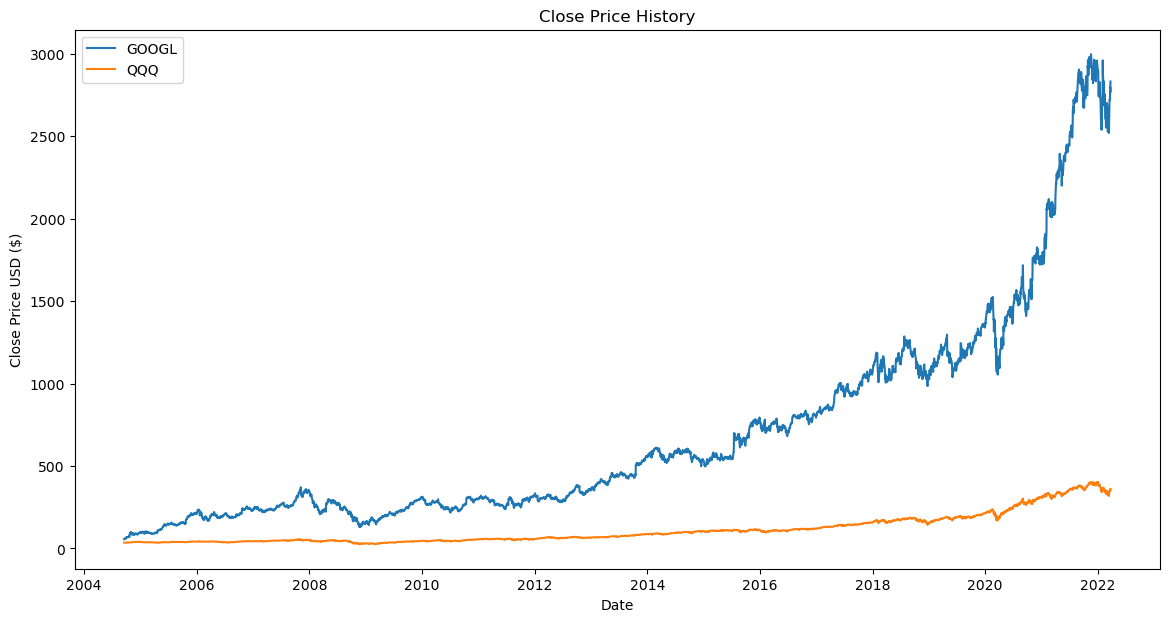

In [17]:
# Plot the close price
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.plot(googl_df['close'], label='GOOGL')
plt.plot(qqq_df['close'], label='QQQ')
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend(loc='upper left')
plt.show()

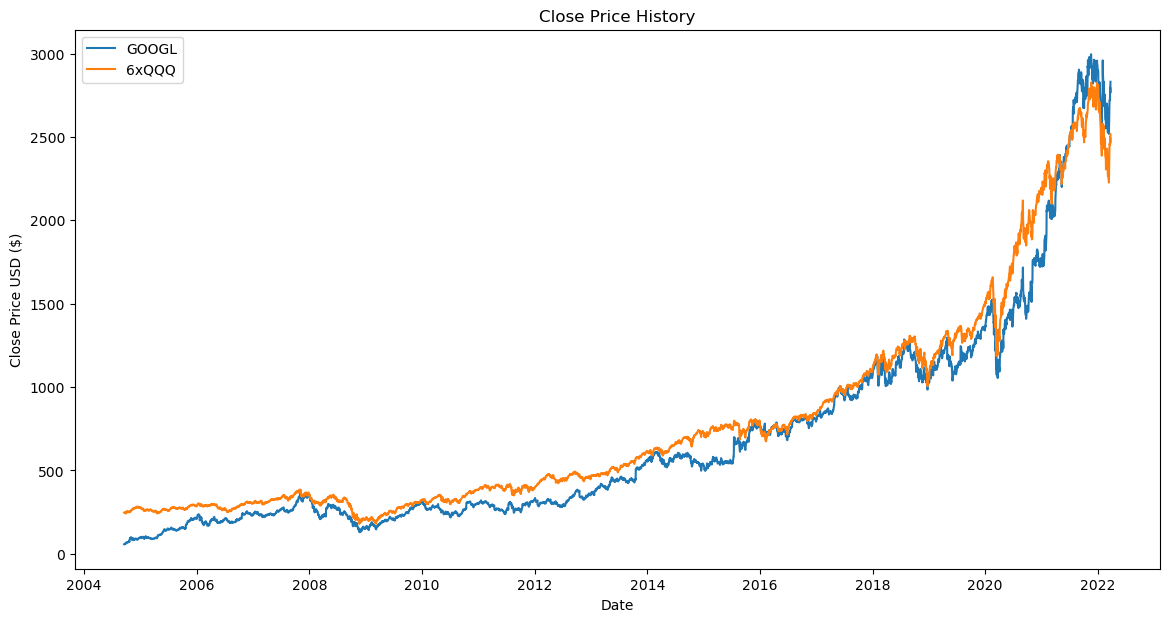

In [19]:
# Scaling QQQ times 7
# Plot the close price
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.plot(googl_df['close'], label='GOOGL')
plt.plot(7 * qqq_df['close'], label='7xQQQ')
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend(loc='upper left')
plt.show()

After scaling the QQQ close price times 7 to improve the quality of the visualization comparing the data, it is clear to see that GOOGL and QQQ follow and very similar curve.

Here below, we have the an exponential line of best fit to show the data

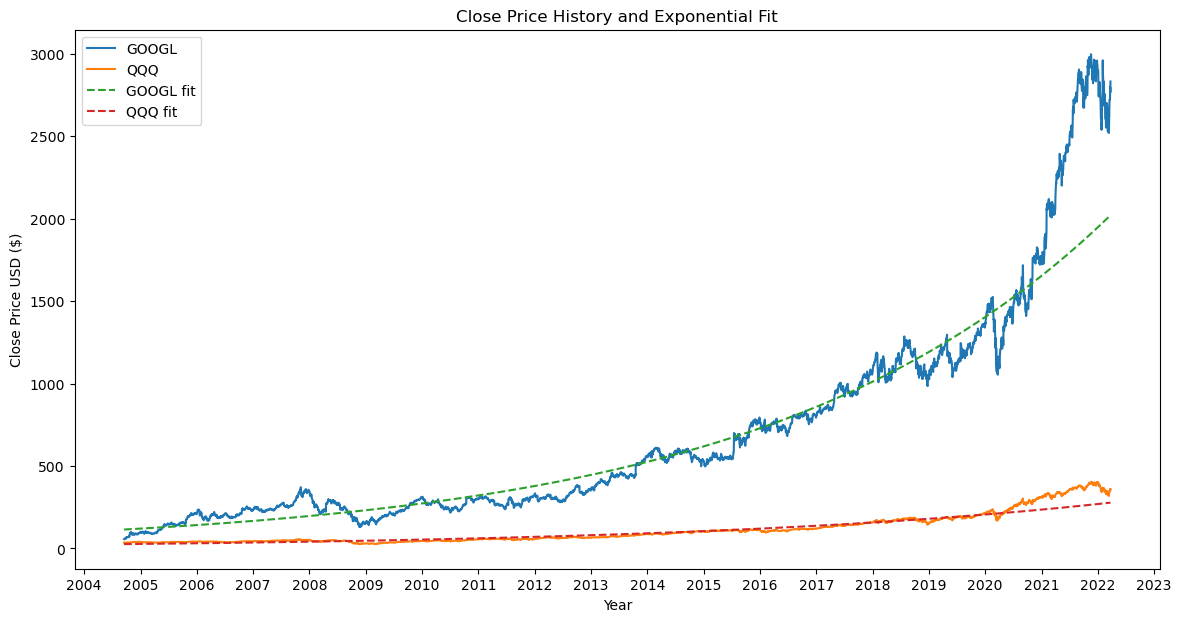

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert the index to a numerical format for curve fitting
x_data_googl = mdates.date2num(googl_df.index.to_pydatetime())
x_data_qqq = mdates.date2num(qqq_df.index.to_pydatetime())

# Fit an exponential curve to the close price data
coeffs_googl = np.polyfit(x_data_googl, np.log(googl_df['close']), 1)
coeffs_qqq = np.polyfit(x_data_qqq, np.log(qqq_df['close']), 1)

# Generate y values for the fitted curves
y_fit_googl = np.exp(np.polyval(coeffs_googl, x_data_googl))
y_fit_qqq = np.exp(np.polyval(coeffs_qqq, x_data_qqq))

# Plot the close price data and the fitted curves
plt.figure(figsize=(14,7))
plt.plot(x_data_googl, googl_df['close'], label='GOOGL', linestyle='-')
plt.plot(x_data_qqq, qqq_df['close'], label='QQQ', linestyle='-')
plt.plot(x_data_googl, y_fit_googl, label='GOOGL fit', linestyle='--')
plt.plot(x_data_qqq, y_fit_qqq, label='QQQ fit', linestyle='--')
plt.title('Close Price History and Exponential Fit')
plt.xlabel('Year')
plt.ylabel('Close Price USD ($)')
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.show()


As we can see using the line of best fit, it shows us the general trend over time, we see that both stocks increase exponentially and are directly correlated with each other. This makes sense, as the QQQ includes the stock of Google and the stocks may be influenced by the same factors, which results in the same movement in the stock market. The main difference is the scales at which the two stocks are listed at.

**Individual Stock Ticker Analysis: GOOGLE**

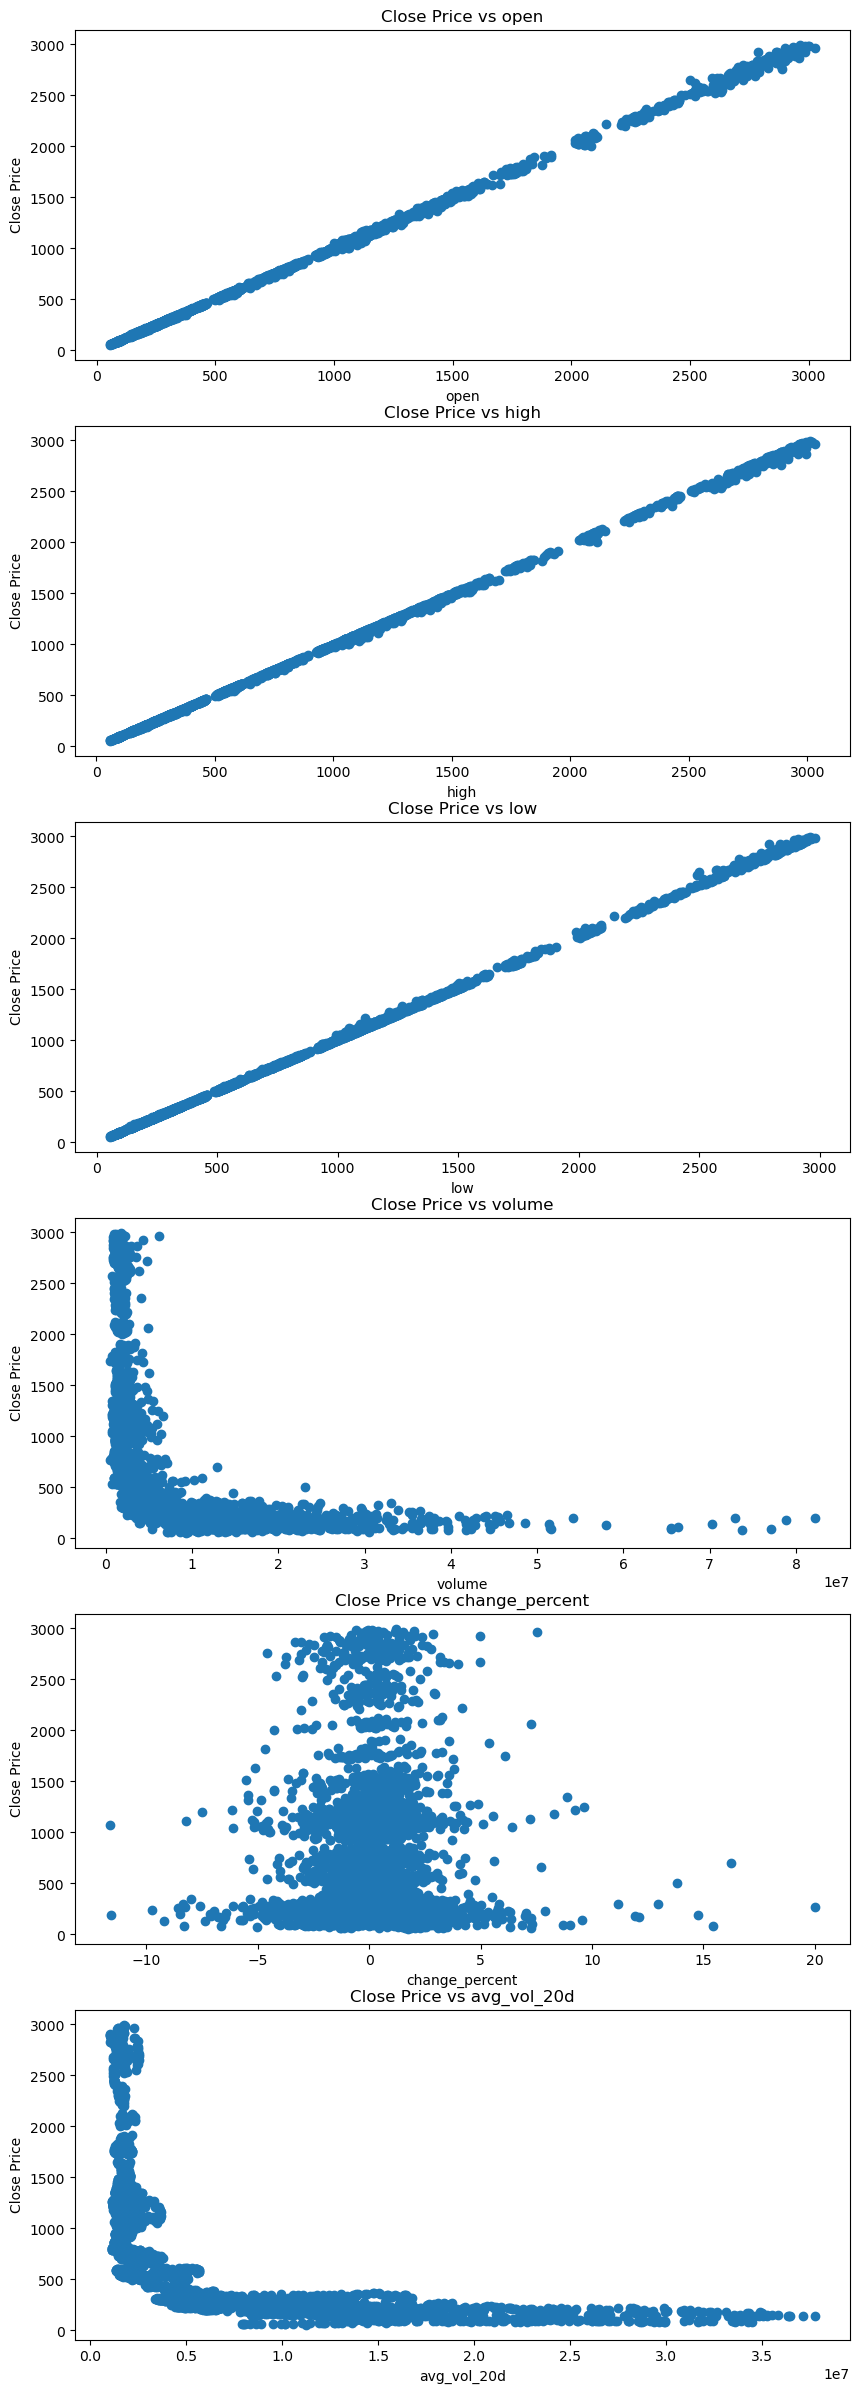

In [7]:
import matplotlib.pyplot as plt

# Get the list of columns except 'close'
columns = [col for col in googl_df.columns if col != 'close' and col!='date']

# Create a figure to hold the subplots
fig, axs = plt.subplots(len(columns), 1, figsize=(10, 5*len(columns)))

# For each column, create a scatter plot with 'close'
for i, col in enumerate(columns):
    axs[i].scatter(googl_df[col], googl_df['close'])
    axs[i].set_title(f'Close Price vs {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Close Price')
# Display the plot
plt.show()


This is the relationship between the closing price with all of our other attributes. Open, high, and close are not of interest since they are just linear plots thus they have a direct relation. Some interests goes into our volume with closing prices, as we see there is a negative correlation, as the price decreases, the volume traded increases. The change percent graph shows a strong distribution near 0, but skewed a bit to the right, thus we can conclude that the Google stock is somewhat stable that is giving positive percent change.

Statistical tests:

In [11]:
# For each column, run a t-test with 'close'
for col in columns:
    print("For", col, ":")
    print("     Correlation value:", googl_df["close"].corr(googl_df[col]))
    t_stat, p_val = scipy.stats.ttest_ind( googl_df['close'], googl_df[col])
    print("     T-Test:", t_stat, ", P_Value:", p_val)

For open :
     Correlation value: 0.9998072574758259
     T-Test: 0.00065269481556192 , P_Value: 0.99947923967837
For high :
     Correlation value: 0.999902310719917
     T-Test: -0.4827128212519919 , P_Value: 0.6293116358073321
For low :
     Correlation value: 0.9999137949760194
     T-Test: 0.515427753224674 , P_Value: 0.6062670581841203
For volume :
     Correlation value: -0.45429662048881764
     T-Test: -55.58112002453979 , P_Value: 0.0
For change_percent :
     Correlation value: 0.007710700778716449
     T-Test: 71.62643098779829 , P_Value: 0.0
For avg_vol_20d :
     Correlation value: -0.530648129180504
     T-Test: -64.96005395356738 , P_Value: 0.0


**Individual Stock Ticker Analysis: Nasdaq**

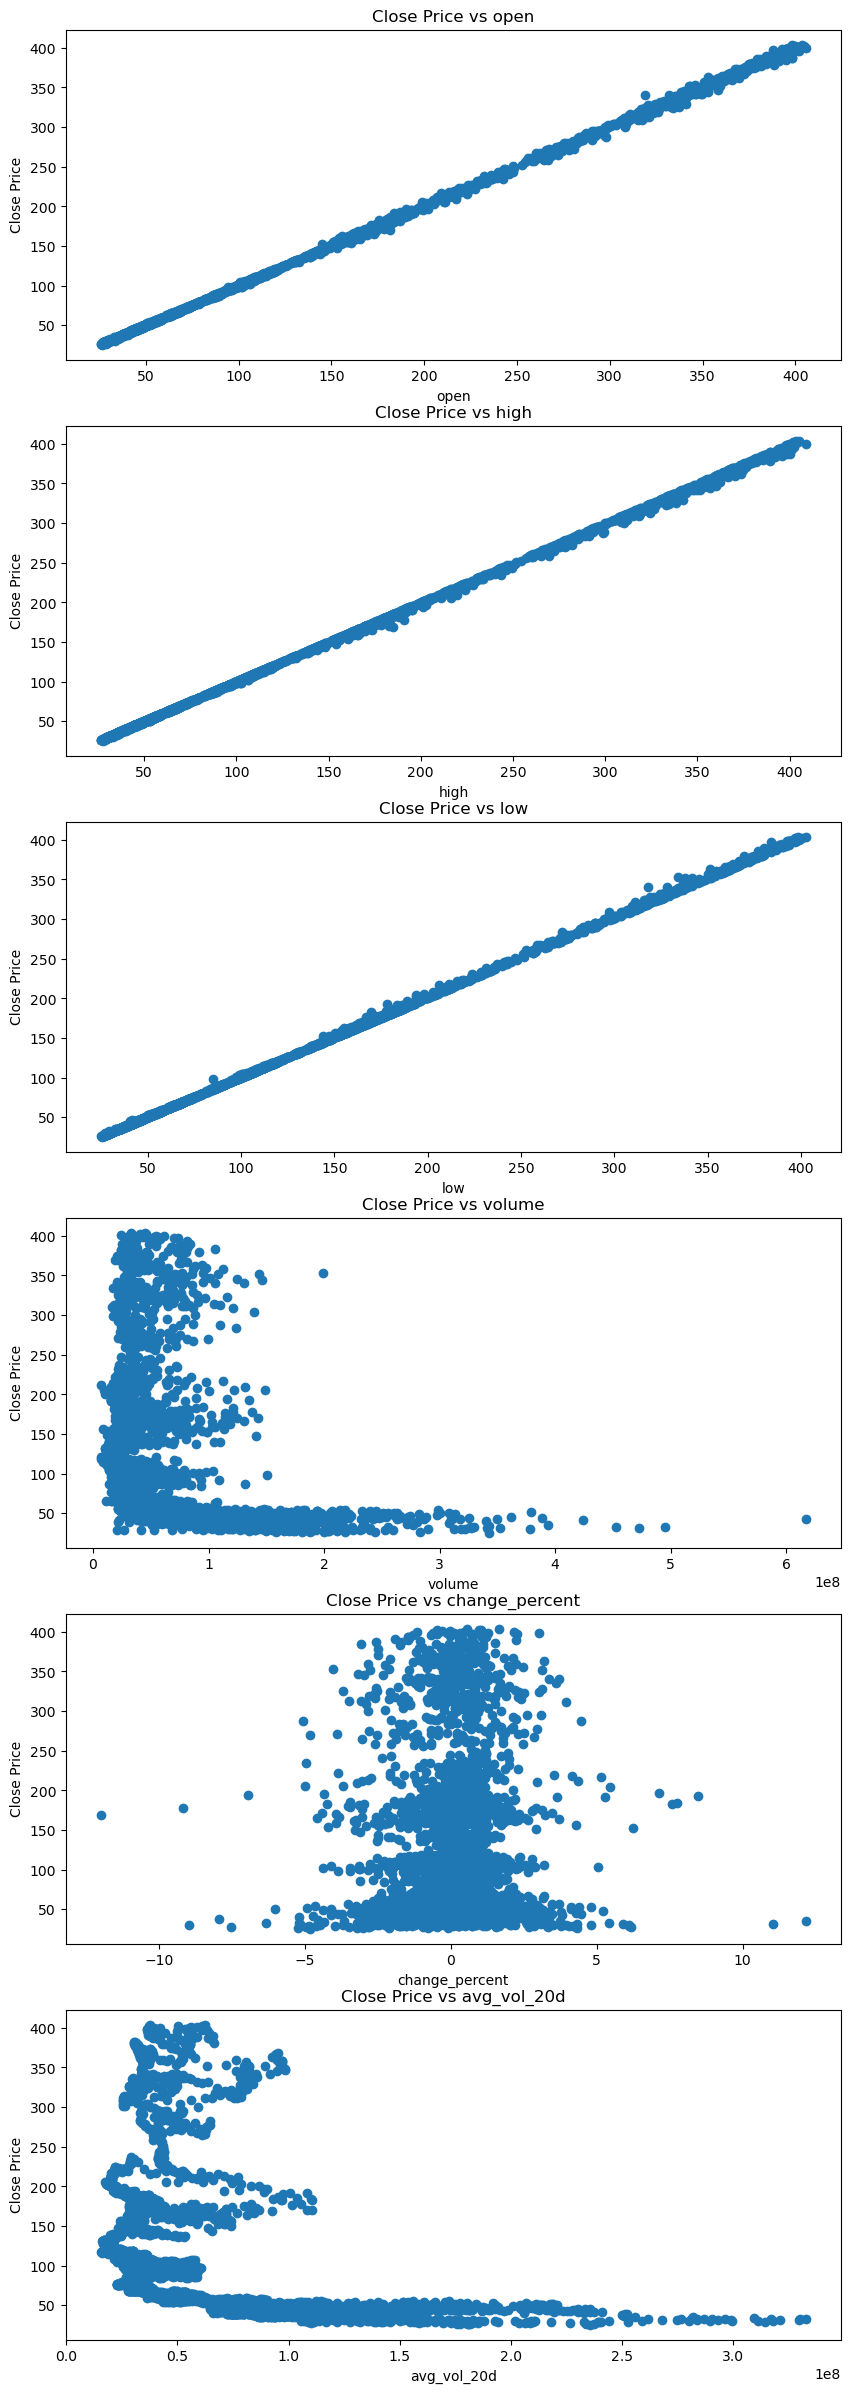

In [12]:
import matplotlib.pyplot as plt

# Get the list of columns except 'close'
columns = [col for col in qqq_df.columns if col != 'close' and col != 'date']

# Create a figure to hold the subplots
fig, axs = plt.subplots(len(columns), 1, figsize=(10, 5*len(columns)))

# For each column, create a scatter plot with 'close'
for i, col in enumerate(columns):
    axs[i].scatter(qqq_df[col], qqq_df['close'])
    axs[i].set_title(f'Close Price vs {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Close Price')
# Display the plot
plt.show()


Similarly with the Google's stock ticker analysis, the high, open, and close has no interest for us. Same analysis from the Google's percent change can be made here as well. The plot of interest is the volume with the closing price where there is more spread out than the Google's version.

Statistical tests:

In [13]:
# For each column, run a t-test with 'close'
for col in columns:
    print("For", col, ":")
    print("     Correlation value:", qqq_df["close"].corr(qqq_df[col]))
    t_stat, p_val = scipy.stats.ttest_ind( qqq_df['close'], qqq_df[col])
    print("     T-Test:", t_stat, ", P_Value:", p_val)

For open :
     Correlation value: 0.9998475486574046
     T-Test: 0.010624678964280791 , P_Value: 0.9915231324202753
For high :
     Correlation value: 0.9999091940587906
     T-Test: -0.3944720409433158 , P_Value: 0.693242100820405
For low :
     Correlation value: 0.9999209314953091
     T-Test: 0.46432501509010293 , P_Value: 0.6424263621909003
For volume :
     Correlation value: -0.39141416481040886
     T-Test: -83.42601905009595 , P_Value: 0.0
For change_percent :
     Correlation value: 0.02070483611795625
     T-Test: 82.49872793189601 , P_Value: 0.0
For avg_vol_20d :
     Correlation value: -0.45008703265619493
     T-Test: -94.64790963639969 , P_Value: 0.0


From both the GOOGL and QQQ t-tests, it is interesting to see for the high and low of each day that, although statistically significant, they are less influential in the closing price compared to the open. Both had high and low p-values in the .60s range. Additionally, it is interesting to see the similar correlation around -.5 for both stocks and their volume data. Volume can prove important in predicting closing price and/or percent change.

Overall conclusions:
We have outlined a few interesting data that correlate (or don't) with the closing price of the GOOGL stock. Future work includes filtering down to the valuable correlations that can help us predict the future of the stock. Additionally, it will be important to use the percent change when comparing GOOGL and QQQ because their price values are on very different scales. The plan is to use this data to see if changes in QQQ lead to changes in GOOGL or vice versa.